<a href="https://colab.research.google.com/github/AnnaPechenina/2016-08-23-unt-github-collaboration/blob/master/Intro_to_Python_Day_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 10 
## Agenda

1.   Neural Network (Tensorflow 2)
2.   Nature language processing


![meme](https://www.meme-arsenal.com/memes/31f994ae57c2e0aa1b49388a5a5a2945.jpg)

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 2 quickstart for beginners

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/beginner"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This short introduction uses [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Load a prebuilt dataset.
1. Build a neural network machine learning model that classifies images.
2. Train this neural network.
3. Evaluate the accuracy of the model.

This tutorial is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. Run all the notebook code cells: Select *Runtime* > *Run all*.

## Set up TensorFlow

Import TensorFlow into your program to get started:

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.2


If you are following along in your own development environment, rather than [Colab](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb), see the [install guide](https://www.tensorflow.org/install) for setting up TensorFlow for development.

Note: Make sure you have upgraded to the latest `pip` to install the TensorFlow 2 package if you are using your own development environment. See the [install guide](https://www.tensorflow.org/install) for details.

## Load a dataset

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the sample data from integers to floating-point numbers:

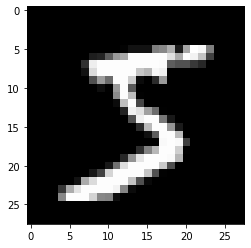

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
from matplotlib import pyplot as plt
import numpy as np
first_image = x_train[0]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()


In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
x_train[0].shape

(28, 28)

In [ ]:
y_train[0]

5

## Build a machine learning model

Build a `tf.keras.Sequential` model by stacking layers.

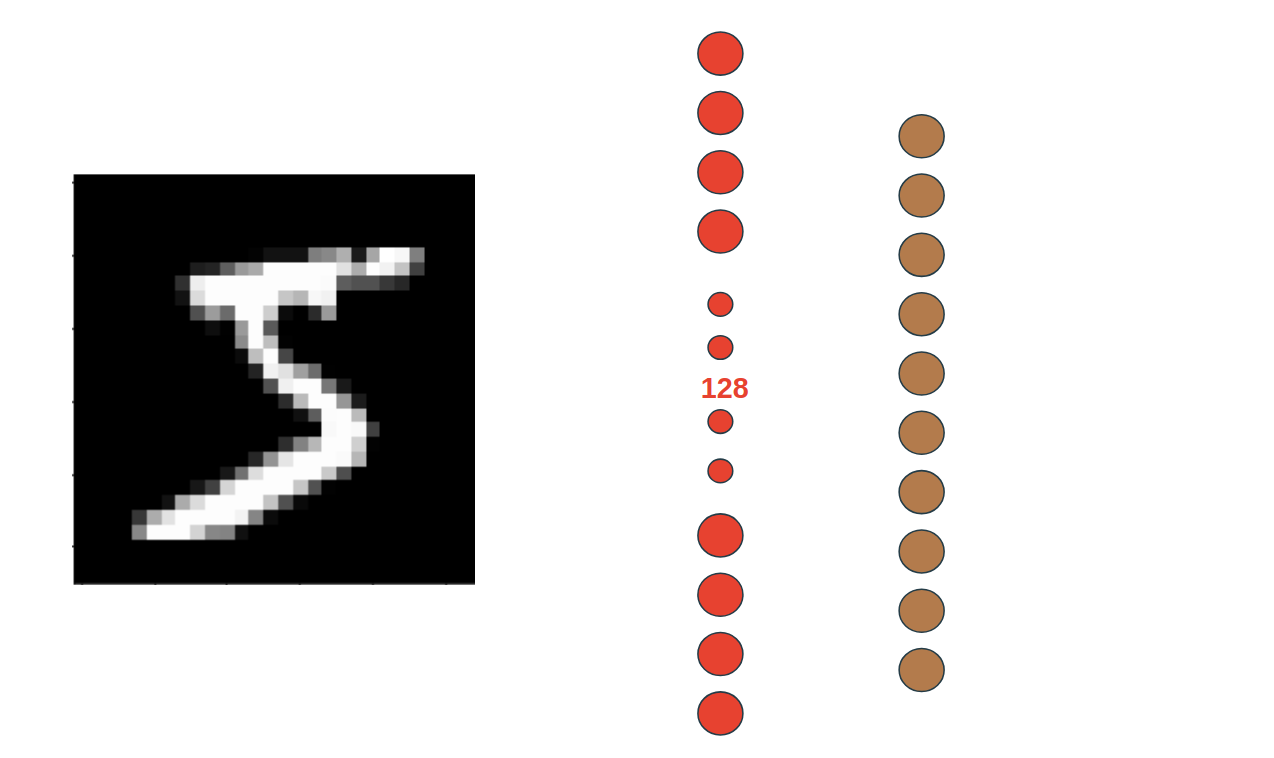

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

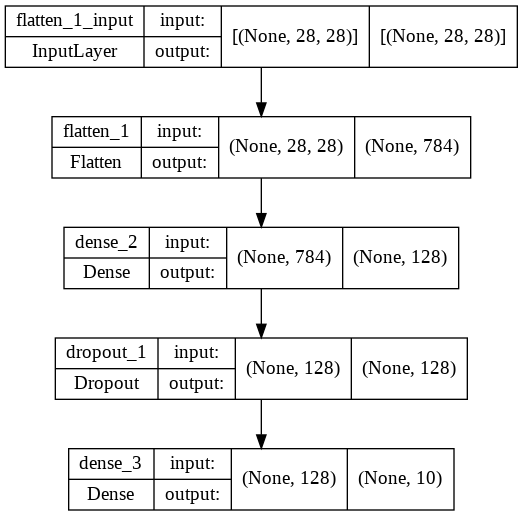

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

For each example, the model returns a vector of [logits](https://developers.google.com/machine-learning/glossary#logits) or [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) scores, one for each class.

In [ ]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.29258153,  0.09159486, -0.1875242 ,  0.54569995,  0.07942391,
         0.04966646,  0.14090368,  0.2332064 , -0.13677779,  0.5137022 ]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to *probabilities* for each class: 

In [ ]:
tf.nn.softmax(predictions).numpy()

array([[0.06496501, 0.0953949 , 0.07216146, 0.15022442, 0.0942409 ,
        0.09147785, 0.10021662, 0.10990723, 0.07591791, 0.14549367]],
      dtype=float32)

Note: It is possible to bake the `tf.nn.softmax` function into the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output. 

Define a loss function for training using `losses.SparseCategoricalCrossentropy`, which takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [ ]:
loss_fn(y_train[:1], predictions).numpy()

2.3916585

Before you start training, configure and compile the model using Keras `Model.compile`. Set the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class to `adam`, set the `loss` to the `loss_fn` function you defined earlier, and specify a metric to be evaluated for the model by setting the `metrics` parameter to `accuracy`.

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## Train and evaluate your model

Use the `Model.fit` method to adjust your model parameters and minimize the loss: 

In [ ]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0652 - accuracy: 0.9797
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0586 - accuracy: 0.9817
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0534 - accuracy: 0.9823
Epoch 4/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0479 - accuracy: 0.9841
Epoch 5/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0449 - accuracy: 0.9858


The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" or "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)".

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0721 - accuracy: 0.9795 - 572ms/epoch - 2ms/step


[0.07208282500505447, 0.9794999957084656]

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[5.88734451e-07, 7.31725303e-09, 4.17670162e-06, 2.42432070e-05,
        4.37175079e-12, 1.30210807e-07, 7.99051526e-13, 9.99969006e-01,
        1.58690955e-06, 3.08308472e-07],
       [8.81324436e-09, 2.79518008e-05, 9.99971628e-01, 3.27736871e-07,
        1.95798270e-16, 6.94401123e-08, 1.18004839e-09, 2.52610450e-14,
        2.20586678e-08, 2.75732247e-14],
       [1.04757009e-06, 9.99006689e-01, 1.14772418e-04, 1.96910696e-05,
        2.45281681e-05, 4.47879756e-05, 1.37574025e-05, 6.91260211e-04,
        8.07886026e-05, 2.71801423e-06],
       [9.99679208e-01, 1.13460160e-07, 2.55377061e-04, 3.04708465e-07,
        2.13649365e-08, 2.17457346e-05, 3.38458594e-05, 9.01030126e-06,
        7.72353985e-08, 2.33222025e-07],
       [1.66434961e-06, 1.70612573e-08, 5.49078004e-06, 6.28324415e-08,
        9.99538422e-01, 1.75931490e-07, 1.21648497e-06, 5.21495531e-05,
        8.06912681e-07, 3.99972079e-04]], dtype=float32)>

## Conclusion

Congratulations! You have trained a machine learning model using a prebuilt dataset using the [Keras](https://www.tensorflow.org/guide/keras/overview) API.

For more examples of using Keras, check out the [tutorials](https://www.tensorflow.org/tutorials/keras/). To learn more about building models with Keras, read the [guides](https://www.tensorflow.org/guide/keras). If you want learn more about loading and preparing data, see the tutorials on [image data loading](https://www.tensorflow.org/tutorials/load_data/images) or [CSV data loading](https://www.tensorflow.org/tutorials/load_data/csv).


<small><a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a> This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.</small>


In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

# spaCy

- Fast, and extensible NLP package for Python
- <https://spacy.io/>
- NOTE: You will need to install this, and then (one time only as well) download the English corpus.

In [ ]:
# Uncomment *one* of the following lines and run this cell OR use Anaconda Navigator to install the package
#!pip install spacy
#pip install spacy
#!conda install -y spacy

In [ ]:
import spacy

In [ ]:
# Comment out the next line when you've run this cell successfully
# !python -m spacy download en_core_web_sm

In [ ]:
# loading up the language model: English
# note that Windows users will probably need to figure out where
# the previous cell installed the library and change the following line accordingly
nlp = spacy.load('en_core_web_sm')

# 0. Data cleaning

In [ ]:
# from Project Gutenberg: Grimms' Fairy Tales
sentences = """
As soon as the time came when he was to declare the secret, he was taken
before the king with the three branches and the golden cup; and the
twelve princesses stood listening behind the door to hear what he would
say. And when the king asked him. ‘Where do my twelve daughters dance at
night?’ he answered, ‘With twelve princes in a castle under ground.’ And
then he told the king all that had happened, and showed him the three
branches and the golden cup which he had brought with him. Then the king
called for the princesses, and asked them whether what the soldier said
was true: and when they saw that they were discovered, and that it was
of no use to deny what had happened, they confessed it all. And the king
asked the soldier which of them he would choose for his wife; and he
answered, ‘I am not very young, so I will have the eldest.’--And they
were married that very day, and the soldier was chosen to be the king’s
heir.

"""

In [ ]:
sentences

'\nAs soon as the time came when he was to declare the secret, he was taken\nbefore the king with the three branches and the golden cup; and the\ntwelve princesses stood listening behind the door to hear what he would\nsay. And when the king asked him. ‘Where do my twelve daughters dance at\nnight?’ he answered, ‘With twelve princes in a castle under ground.’ And\nthen he told the king all that had happened, and showed him the three\nbranches and the golden cup which he had brought with him. Then the king\ncalled for the princesses, and asked them whether what the soldier said\nwas true: and when they saw that they were discovered, and that it was\nof no use to deny what had happened, they confessed it all. And the king\nasked the soldier which of them he would choose for his wife; and he\nanswered, ‘I am not very young, so I will have the eldest.’--And they\nwere married that very day, and the soldier was chosen to be the king’s\nheir.\n\n'

### Section goal: calculate the frequency of each word
- See which words are more frequent.
- Generate more meaningful summary for the above paragraph.

## 0-1. lowering the case

In [ ]:
type(sentences)

str

In [ ]:
sentences

'\nAs soon as the time came when he was to declare the secret, he was taken\nbefore the king with the three branches and the golden cup; and the\ntwelve princesses stood listening behind the door to hear what he would\nsay. And when the king asked him. ‘Where do my twelve daughters dance at\nnight?’ he answered, ‘With twelve princes in a castle under ground.’ And\nthen he told the king all that had happened, and showed him the three\nbranches and the golden cup which he had brought with him. Then the king\ncalled for the princesses, and asked them whether what the soldier said\nwas true: and when they saw that they were discovered, and that it was\nof no use to deny what had happened, they confessed it all. And the king\nasked the soldier which of them he would choose for his wife; and he\nanswered, ‘I am not very young, so I will have the eldest.’--And they\nwere married that very day, and the soldier was chosen to be the king’s\nheir.\n\n'

In [ ]:
sent_low = sentences.lower()

In [ ]:
sent_low

'\nas soon as the time came when he was to declare the secret, he was taken\nbefore the king with the three branches and the golden cup; and the\ntwelve princesses stood listening behind the door to hear what he would\nsay. and when the king asked him. ‘where do my twelve daughters dance at\nnight?’ he answered, ‘with twelve princes in a castle under ground.’ and\nthen he told the king all that had happened, and showed him the three\nbranches and the golden cup which he had brought with him. then the king\ncalled for the princesses, and asked them whether what the soldier said\nwas true: and when they saw that they were discovered, and that it was\nof no use to deny what had happened, they confessed it all. and the king\nasked the soldier which of them he would choose for his wife; and he\nanswered, ‘i am not very young, so i will have the eldest.’--and they\nwere married that very day, and the soldier was chosen to be the king’s\nheir.\n\n'

## 0-2. remove punctuation and special characters

#### Exclude special characters one by one

In [ ]:
# from https://www.programiz.com/python-programming/examples/remove-punctuation
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~‘’''' # list of special characters you want to exclude
sent_low_pnct = ""
for char in sent_low:
    if char not in punctuations:
        sent_low_pnct = sent_low_pnct + char

sent_low_pnct

'\nas soon as the time came when he was to declare the secret he was taken\nbefore the king with the three branches and the golden cup and the\ntwelve princesses stood listening behind the door to hear what he would\nsay and when the king asked him where do my twelve daughters dance at\nnight he answered with twelve princes in a castle under ground and\nthen he told the king all that had happened and showed him the three\nbranches and the golden cup which he had brought with him then the king\ncalled for the princesses and asked them whether what the soldier said\nwas true and when they saw that they were discovered and that it was\nof no use to deny what had happened they confessed it all and the king\nasked the soldier which of them he would choose for his wife and he\nanswered i am not very young so i will have the eldestand they\nwere married that very day and the soldier was chosen to be the kings\nheir\n\n'

#### Alternatively, we can use regular expression to remove punctuations
- So we don't have to list up all possible special characters that we want to remove
- https://docs.python.org/3.4/library/re.html
- https://en.wikipedia.org/wiki/Regular_expression

https://www.w3schools.com/python/python_regex.asp

In [ ]:
sent_low

'\nas soon as the time came when he was to declare the secret, he was taken\nbefore the king with the three branches and the golden cup; and the\ntwelve princesses stood listening behind the door to hear what he would\nsay. and when the king asked him. ‘where do my twelve daughters dance at\nnight?’ he answered, ‘with twelve princes in a castle under ground.’ and\nthen he told the king all that had happened, and showed him the three\nbranches and the golden cup which he had brought with him. then the king\ncalled for the princesses, and asked them whether what the soldier said\nwas true: and when they saw that they were discovered, and that it was\nof no use to deny what had happened, they confessed it all. and the king\nasked the soldier which of them he would choose for his wife; and he\nanswered, ‘i am not very young, so i will have the eldest.’--and they\nwere married that very day, and the soldier was chosen to be the king’s\nheir.\n\n'

In [ ]:
import re
sent_low_pnct2 = re.sub(r'[^\w\s]+', ' ', sent_low)

In [ ]:
sent_low_pnct2

'\nas soon as the time came when he was to declare the secret  he was taken\nbefore the king with the three branches and the golden cup  and the\ntwelve princesses stood listening behind the door to hear what he would\nsay  and when the king asked him   where do my twelve daughters dance at\nnight  he answered   with twelve princes in a castle under ground  and\nthen he told the king all that had happened  and showed him the three\nbranches and the golden cup which he had brought with him  then the king\ncalled for the princesses  and asked them whether what the soldier said\nwas true  and when they saw that they were discovered  and that it was\nof no use to deny what had happened  they confessed it all  and the king\nasked the soldier which of them he would choose for his wife  and he\nanswered   i am not very young  so i will have the eldest and they\nwere married that very day  and the soldier was chosen to be the king s\nheir \n\n'

- However, special character ```\n``` (linebreak) still exists in both cases. Let's remove these additionally.

In [ ]:
import os
os.linesep

'\n'

In [ ]:
sent_low_pnct = sent_low_pnct.replace('\n', " ")
sent_low_pnct

' as soon as the time came when he was to declare the secret he was taken before the king with the three branches and the golden cup and the twelve princesses stood listening behind the door to hear what he would say and when the king asked him where do my twelve daughters dance at night he answered with twelve princes in a castle under ground and then he told the king all that had happened and showed him the three branches and the golden cup which he had brought with him then the king called for the princesses and asked them whether what the soldier said was true and when they saw that they were discovered and that it was of no use to deny what had happened they confessed it all and the king asked the soldier which of them he would choose for his wife and he answered i am not very young so i will have the eldestand they were married that very day and the soldier was chosen to be the kings heir  '

### And one more way...

In [ ]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
table = str.maketrans(dict.fromkeys(string.punctuation))
no_punctuation= sent_low_pnct.translate(table)

print(no_punctuation)

 as soon as the time came when he was to declare the secret he was taken before the king with the three branches and the golden cup and the twelve princesses stood listening behind the door to hear what he would say and when the king asked him where do my twelve daughters dance at night he answered with twelve princes in a castle under ground and then he told the king all that had happened and showed him the three branches and the golden cup which he had brought with him then the king called for the princesses and asked them whether what the soldier said was true and when they saw that they were discovered and that it was of no use to deny what had happened they confessed it all and the king asked the soldier which of them he would choose for his wife and he answered i am not very young so i will have the eldestand they were married that very day and the soldier was chosen to be the kings heir  


Regular expressions:

^ means "beginning of string" 
UNLESS it's in [ ], in which case it means "not"

r'^The' # means The at the beginning of a string
r'^[The]' # means any one of T or h or e at the beginning of a string
t'^[^The]' # means any character other than T,h,or e at the beginning

### So... at least 3 possible ways to replace characters!

## 0-3. Remove stop words

- Stop words usually refers to the most common words in a language
    - No single universal stopwords
    - Often stopwords are removed to improve the performance of NLP models
    - https://en.wikipedia.org/wiki/Stop_words
    - https://en.wikipedia.org/wiki/Most_common_words_in_English

#### Import the list of stop words from ```spaCy```

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
import numpy as np

In [ ]:
STOP_WORDS

#### Goal: We are going to count the frequency of each word from the paragraph, to see which words can be used to represent the paragraph's content. 

#### What if we do not remove stopwords?

- Note that our paragraph is stored as a single string object...

In [ ]:
sent_low_pnct

' as soon as the time came when he was to declare the secret he was taken before the king with the three branches and the golden cup and the twelve princesses stood listening behind the door to hear what he would say and when the king asked him where do my twelve daughters dance at night he answered with twelve princes in a castle under ground and then he told the king all that had happened and showed him the three branches and the golden cup which he had brought with him then the king called for the princesses and asked them whether what the soldier said was true and when they saw that they were discovered and that it was of no use to deny what had happened they confessed it all and the king asked the soldier which of them he would choose for his wife and he answered i am not very young so i will have the eldestand they were married that very day and the soldier was chosen to be the kings heir  '

- Split the paragraph into a list of words

In [ ]:
words = sent_low_pnct.split()

In [ ]:
words

- Count the words from the list
- Words that can occur in any kind of paragraphs...?

In [ ]:
d = {}
for word in words:
    if word in d:
        d[word] = d[word] + 1
    else:
        d[word] = 1
d

In [ ]:
from collections import Counter

In [ ]:
Counter(words).most_common(20)

[('the', 19),
 ('and', 12),
 ('he', 8),
 ('was', 5),
 ('king', 5),
 ('to', 4),
 ('that', 4),
 ('they', 4),
 ('when', 3),
 ('with', 3),
 ('twelve', 3),
 ('what', 3),
 ('asked', 3),
 ('him', 3),
 ('had', 3),
 ('soldier', 3),
 ('as', 2),
 ('three', 2),
 ('branches', 2),
 ('golden', 2)]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

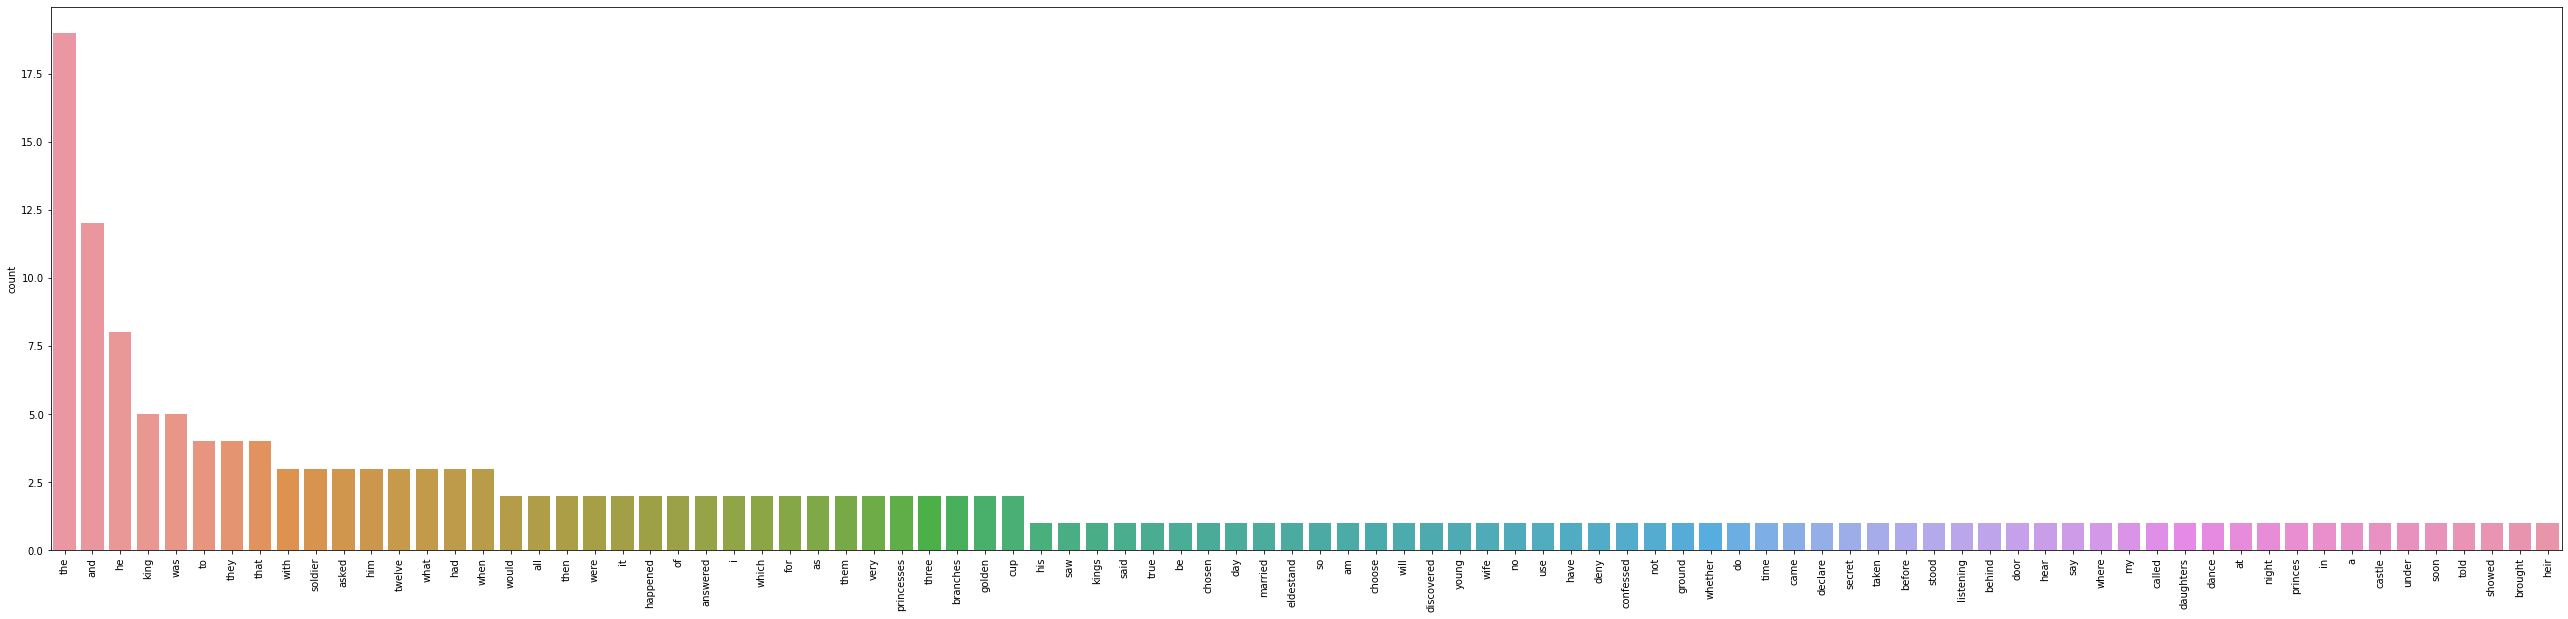

In [ ]:
plt.figure(figsize=(45,10))
sns.countplot(x=words, order=pd.Series(words).value_counts().index)
# sns.countplot(words_nostop, order=[counted[0] for counted in Counter(words_nostop).most_common()])
plt.xticks(rotation=90)
plt.show()

#### When we removed stopwords:

In [ ]:
# split sentence into words
words_nostop = list()
for word in words:
    if word not in STOP_WORDS:
        words_nostop.append(word)
# words_nostop = [word for word in words if word not in STOP_WORDS]

In [ ]:
words_nostop

['soon',
 'time',
 'came',
 'declare',
 'secret',
 'taken',
 'king',
 'branches',
 'golden',
 'cup',
 'princesses',
 'stood',
 'listening',
 'door',
 'hear',
 'king',
 'asked',
 'daughters',
 'dance',
 'night',
 'answered',
 'princes',
 'castle',
 'ground',
 'told',
 'king',
 'happened',
 'showed',
 'branches',
 'golden',
 'cup',
 'brought',
 'king',
 'called',
 'princesses',
 'asked',
 'soldier',
 'said',
 'true',
 'saw',
 'discovered',
 'use',
 'deny',
 'happened',
 'confessed',
 'king',
 'asked',
 'soldier',
 'choose',
 'wife',
 'answered',
 'young',
 'eldestand',
 'married',
 'day',
 'soldier',
 'chosen',
 'kings',
 'heir']

- More comprehensible, and unique list or words!

In [ ]:
Counter(words_nostop).most_common(10)

[('king', 5),
 ('asked', 3),
 ('soldier', 3),
 ('branches', 2),
 ('golden', 2),
 ('cup', 2),
 ('princesses', 2),
 ('answered', 2),
 ('happened', 2),
 ('soon', 1)]

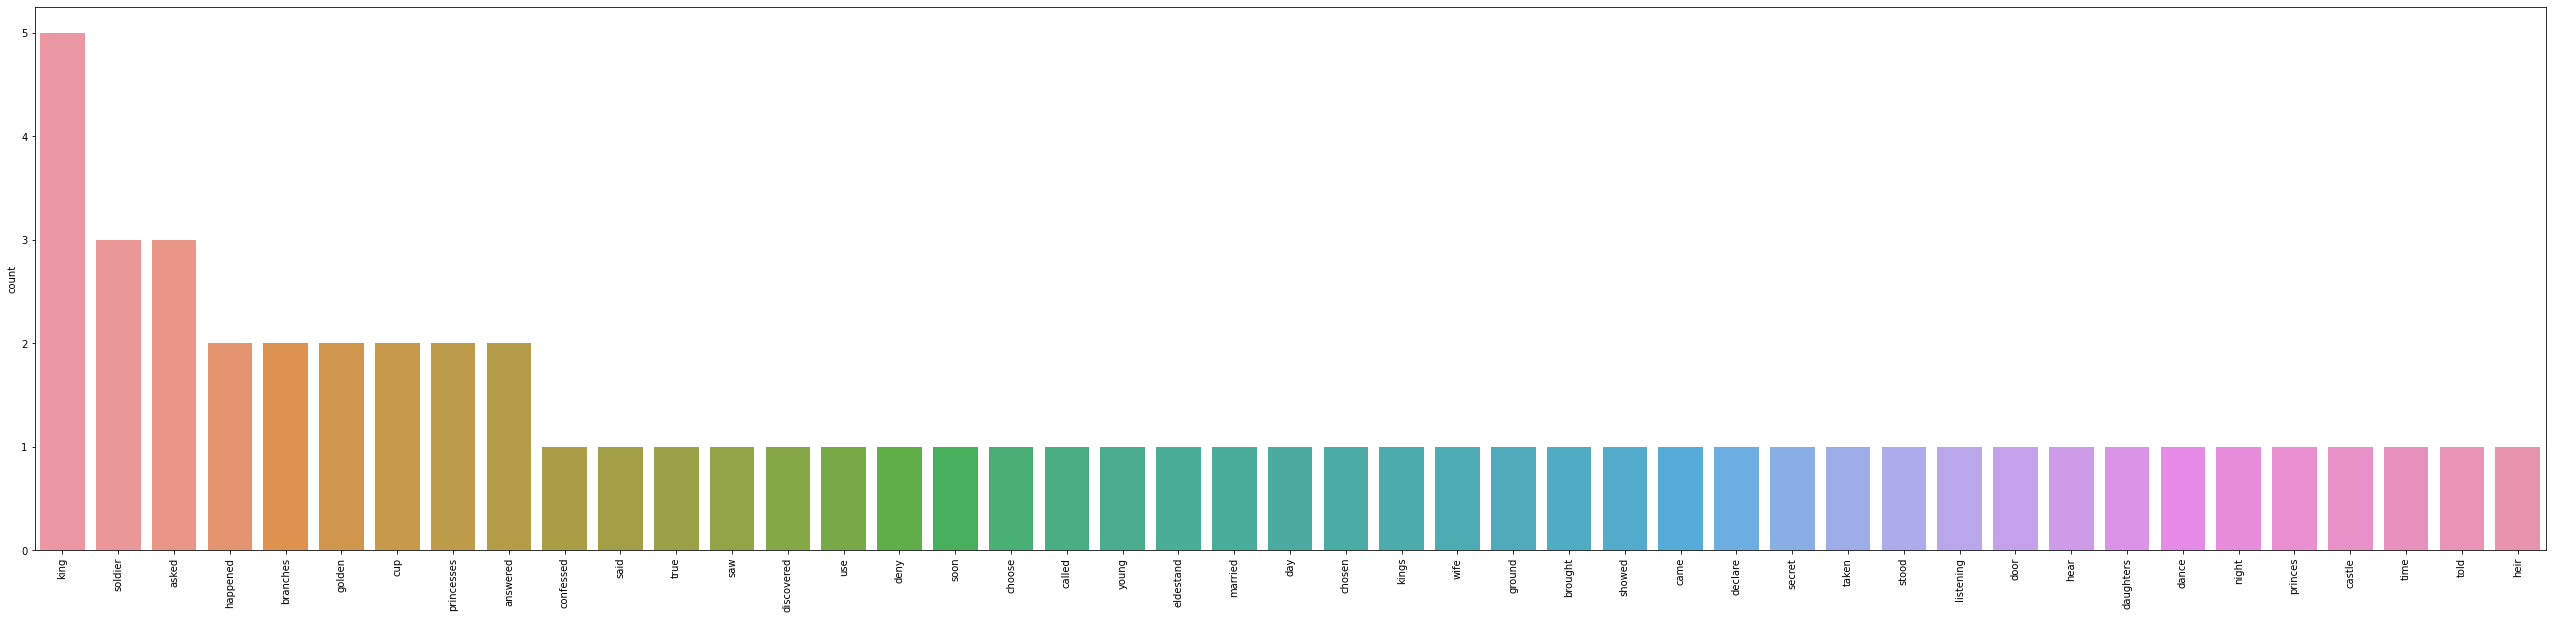

In [ ]:
plt.figure(figsize=(45,10))
sns.countplot(x=words_nostop, order=pd.Series(words_nostop).value_counts().index)
# sns.countplot(words_nostop, order=[counted[0] for counted in Counter(words_nostop).most_common()])
plt.xticks(rotation=90)
plt.show()

# 1. Extracting linguistic features from spaCy

## 1-1. Tokenize
- Token: a semantic unit for analysis
    - (Loosely) equal term for word
        - ```sent_low_pnct.split()```
    - Tricky cases
        - aren't $\rightarrow$ ![](https://nlp.stanford.edu/IR-book/html/htmledition/img88.png) ![](https://nlp.stanford.edu/IR-book/html/htmledition/img89.png) ? ![](https://nlp.stanford.edu/IR-book/html/htmledition/img86.png) ?
        - O'Neil $\rightarrow$ ![](https://nlp.stanford.edu/IR-book/html/htmledition/img83.png) ? ![](https://nlp.stanford.edu/IR-book/html/htmledition/img84.png) ![](https://nlp.stanford.edu/IR-book/html/htmledition/img81.png) ?
        - https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html
- In ```spaCy```:
    - Many token types, like word, puntuation symbol, whitespace, etc.

### Let's dissect the sentence!

- initiating the ```spaCy``` object 

In [ ]:
# examples partially taken from https://nlpforhackers.io/complete-guide-to-spacy/
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
type(nlp)

spacy.lang.en.English

- Our sentence: "Hello World!"
    - Pass the sentence string to the ```spaCy``` object ```nlp```

In [ ]:
doc = nlp("Hello World!")

- The sentence is considered as a short document.

In [ ]:
print(type(doc), doc)

<class 'spacy.tokens.doc.Doc'> Hello World!


- As importing the sentence string above, ```spaCy``` split the sentence into tokens (tokenization!)

In [ ]:
for i,token in enumerate(doc):
    print(i, token)

0 Hello
1 World
2 !


- With index information (location from the sentence) of each token

| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10| 11|
|---|---|---|---|---|---|---|---|---|---|---|---|
| H | e | l | l | o | _ | W | o | r | l | d | ! |

In [ ]:
for i, token in enumerate(doc):
    print(i, token.text, token.idx) 


0 Hello 0
1 World 6
2 ! 11


- And many more!
    - https://spacy.io/api/token#attributes

In [ ]:
sentences

'\nAs soon as the time came when he was to declare the secret, he was taken\nbefore the king with the three branches and the golden cup; and the\ntwelve princesses stood listening behind the door to hear what he would\nsay. And when the king asked him. ‘Where do my twelve daughters dance at\nnight?’ he answered, ‘With twelve princes in a castle under ground.’ And\nthen he told the king all that had happened, and showed him the three\nbranches and the golden cup which he had brought with him. Then the king\ncalled for the princesses, and asked them whether what the soldier said\nwas true: and when they saw that they were discovered, and that it was\nof no use to deny what had happened, they confessed it all. And the king\nasked the soldier which of them he would choose for his wife; and he\nanswered, ‘I am not very young, so I will have the eldest.’--And they\nwere married that very day, and the soldier was chosen to be the king’s\nheir.\n\n'

In [ ]:
doc = nlp(sentences)

print("text\tidx\tlemma\tlower\tpunct\tspace\tshape\tPOS")
for token in doc:
    if token.is_space:
        print("SPACE")
    else:
        print("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\t{7}".format(
            token.text,
            token.idx,
            token.lemma_,
            token.lower_,
            token.is_punct,
            token.is_space,
            token.shape_,
            token.pos_
    ))


## 1-2. Sentence detection

- For the document with multiple sentences, we would need to separate  each sentence.
- In ```spaCy```, the job is more convenient (and would cause less mistakes) than using regular expression

In [ ]:
sentences

'\nAs soon as the time came when he was to declare the secret, he was taken\nbefore the king with the three branches and the golden cup; and the\ntwelve princesses stood listening behind the door to hear what he would\nsay. And when the king asked him. ‘Where do my twelve daughters dance at\nnight?’ he answered, ‘With twelve princes in a castle under ground.’ And\nthen he told the king all that had happened, and showed him the three\nbranches and the golden cup which he had brought with him. Then the king\ncalled for the princesses, and asked them whether what the soldier said\nwas true: and when they saw that they were discovered, and that it was\nof no use to deny what had happened, they confessed it all. And the king\nasked the soldier which of them he would choose for his wife; and he\nanswered, ‘I am not very young, so I will have the eldest.’--And they\nwere married that very day, and the soldier was chosen to be the king’s\nheir.\n\n'

In [ ]:
# same document, but initiate as the spaCy object...
doc = nlp(sentences)

- Sentences are stored as a generator object
    - Instead of storing sentences as a list, each sentence is stored as a item in the generator object 
    - Iteratable (i.e., can be used in a for loop)
    - More efficient memory use
    - https://wiki.python.org/moin/Generators

In [ ]:
doc.sents

- Printing sentences with the index number

In [ ]:
for i, sent in enumerate(doc.sents):
    print(i, sent)

## 1-3. POS tagging

- I want to find words with particular part-of-speech!
- Different part-of-speech words carry different information
    - e.g., noun (subject), verb (action term), adjective (quality of the object) 
- https://spacy.io/api/annotation#pos-tagging

- Yelp review!

In [ ]:
# from https://www.yelp.com/biz/ajishin-novi?hrid=juA4Zn2TX7845vNFn4syBQ&utm_campaign=www_review_share_popup&utm_medium=copy_link&utm_source=(direct)
doc = nlp("""One of the best Japanese restaurants in Novi. Simple food, great taste, amazingly price. I visit this place a least twice month.""")

- multiple sentences exist in a document

In [ ]:
for i, sent in enumerate(doc.sents):
    print(i, sent)

0 One of the best Japanese restaurants in Novi.
1 Simple food, great taste, amazingly price.
2 I visit this place a least twice month.


- Question: which words are adjective (ADJ)?

In [ ]:
for i, sent in enumerate(doc.sents):
    #print("__sentence__:", i)
    #print("_token_ \t _POS_")
    for token in sent:
        if token.pos_ == 'ADJ':
            print(token.text, "\t", token.pos_)

best 	 ADJ
Japanese 	 ADJ
Simple 	 ADJ
great 	 ADJ
least 	 ADJ
twice 	 ADJ


best, Japanese, Simple, great, least, twice

## Named Entity Recognition

In [ ]:
doc = nlp("""Democrat Stacey Abrams was trailing in her bid to become the nation’s first female African-American governor, but her campaign said voting problems as well as uncounted absentee and provisional ballots could force a runoff.""")
#doc = nlp(sentences)
print([(X.text, X.label_) for X in doc.ents])

for i, sent in enumerate(doc.sents):
    print("__sentence__:", i)
    print("_token_ \t _POS_")
    for token in sent:
        print(token.text, "\t", token.pos_)



[('Democrat', 'NORP'), ('Stacey Abrams', 'PERSON'), ('first', 'ORDINAL'), ('African-American', 'NORP')]
__sentence__: 0
_token_ 	 _POS_
Democrat 	 PROPN
Stacey 	 PROPN
Abrams 	 PROPN
was 	 AUX
trailing 	 VERB
in 	 ADP
her 	 PRON
bid 	 NOUN
to 	 PART
become 	 VERB
the 	 DET
nation 	 NOUN
’s 	 PART
first 	 ADJ
female 	 ADJ
African 	 PROPN
- 	 PUNCT
American 	 ADJ
governor 	 NOUN
, 	 PUNCT
but 	 CCONJ
her 	 PRON
campaign 	 NOUN
said 	 VERB
voting 	 VERB
problems 	 NOUN
as 	 ADV
well 	 ADV
as 	 ADP
uncounted 	 ADJ
absentee 	 NOUN
and 	 CCONJ
provisional 	 ADJ
ballots 	 NOUN
could 	 AUX
force 	 VERB
a 	 DET
runoff 	 NOUN
. 	 PUNCT


In [ ]:
url = 'https://fivethirtyeight.com/features/remembering-alex-trebek-the-man-with-all-the-answers/'

In [ ]:
# !pip install html5lib bs4

In [ ]:
from bs4 import BeautifulSoup
import requests
import re
def url_to_string(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    for script in soup(["script", "style", 'aside']):
        script.extract()
    return " ".join(re.split(r'[\n\t]+', soup.get_text()))
ny_bb = url_to_string(url)
article = nlp(ny_bb)
len(article.ents)

95

In [ ]:
article

   Remembering Alex Trebek, The Man With All The Answers | FiveThirtyEight                     Skip to main content FiveThirtyEight Search Search ABC News Menu Remembering Alex Trebek, The Man With All The Answers Share on Facebook Share on Twitter Politics Sports Science Podcasts Video ABC News Latest Forecasts For The 2022 Midterm Elections Nov. 9, 2020, at 4:09 PM Remembering Alex Trebek, The Man With All The Answers By Oliver Roeder Filed under Jeopardy! FacebookTwitterEmailLink   PHOTO ILLUSTRATION BY FIVETHIRTYEIGHT / GETTY IMAGES For decades, I’ve tuned into the trivia game show “Jeopardy!” for the facts. On Sunday, the show lost its judicious leader, Alex Trebek, who died at age 80 after a battle with cancer. Trebek had hosted “Jeopardy!” for my entire life. He began in 1984 and hosted every episode since — save for April Fool’s Day in 1997 when he and Pat Sajak of “Wheel of Fortune” swapped places — more than 8,000 half-hour shows in all. For many, watching Trebek was ritualis

In [ ]:
labels = [(x.label_,x.text) for x in article.ents]
#labels
Counter(labels)

Counter({('CARDINAL', '47'): 1,
         ('CARDINAL', '74'): 1,
         ('CARDINAL', 'more than 400,000'): 1,
         ('CARDINAL', 'more than 8,000'): 1,
         ('CARDINAL', 'three'): 1,
         ('CARDINAL', 'two'): 1,
         ('DATE', '1984'): 2,
         ('DATE', '2014'): 1,
         ('DATE', '2022'): 3,
         ('DATE', 'April Fool’s Day in 1997'): 1,
         ('DATE', 'FiveThirtyEight'): 1,
         ('DATE', 'March 2019'): 1,
         ('DATE', 'Nov. 9, 2020,'): 1,
         ('DATE', 'Sunday'): 1,
         ('DATE', 'age 80'): 1,
         ('DATE', 'daily'): 1,
         ('DATE', 'decades'): 1,
         ('DATE', 'last spring'): 1,
         ('DATE', 'the last few years'): 1,
         ('DATE', 'the past few years'): 1,
         ('DATE', 'this past Friday'): 1,
         ('DATE', 'three more years'): 1,
         ('GPE', 'Austin'): 1,
         ('GPE', 'Heathrow'): 1,
         ('GPE', 'Molière'): 1,
         ('GPE', 'the New Republic'): 1,
         ('LOC', 'the Cook Strait'): 1,
      

In [ ]:
labels = [x.label_ for x in article.ents]
Counter(labels)

Counter({'CARDINAL': 6,
         'DATE': 19,
         'GPE': 4,
         'LOC': 1,
         'NORP': 6,
         'ORG': 16,
         'PERSON': 28,
         'PRODUCT': 1,
         'TIME': 1,
         'WORK_OF_ART': 13})

In [ ]:
labels

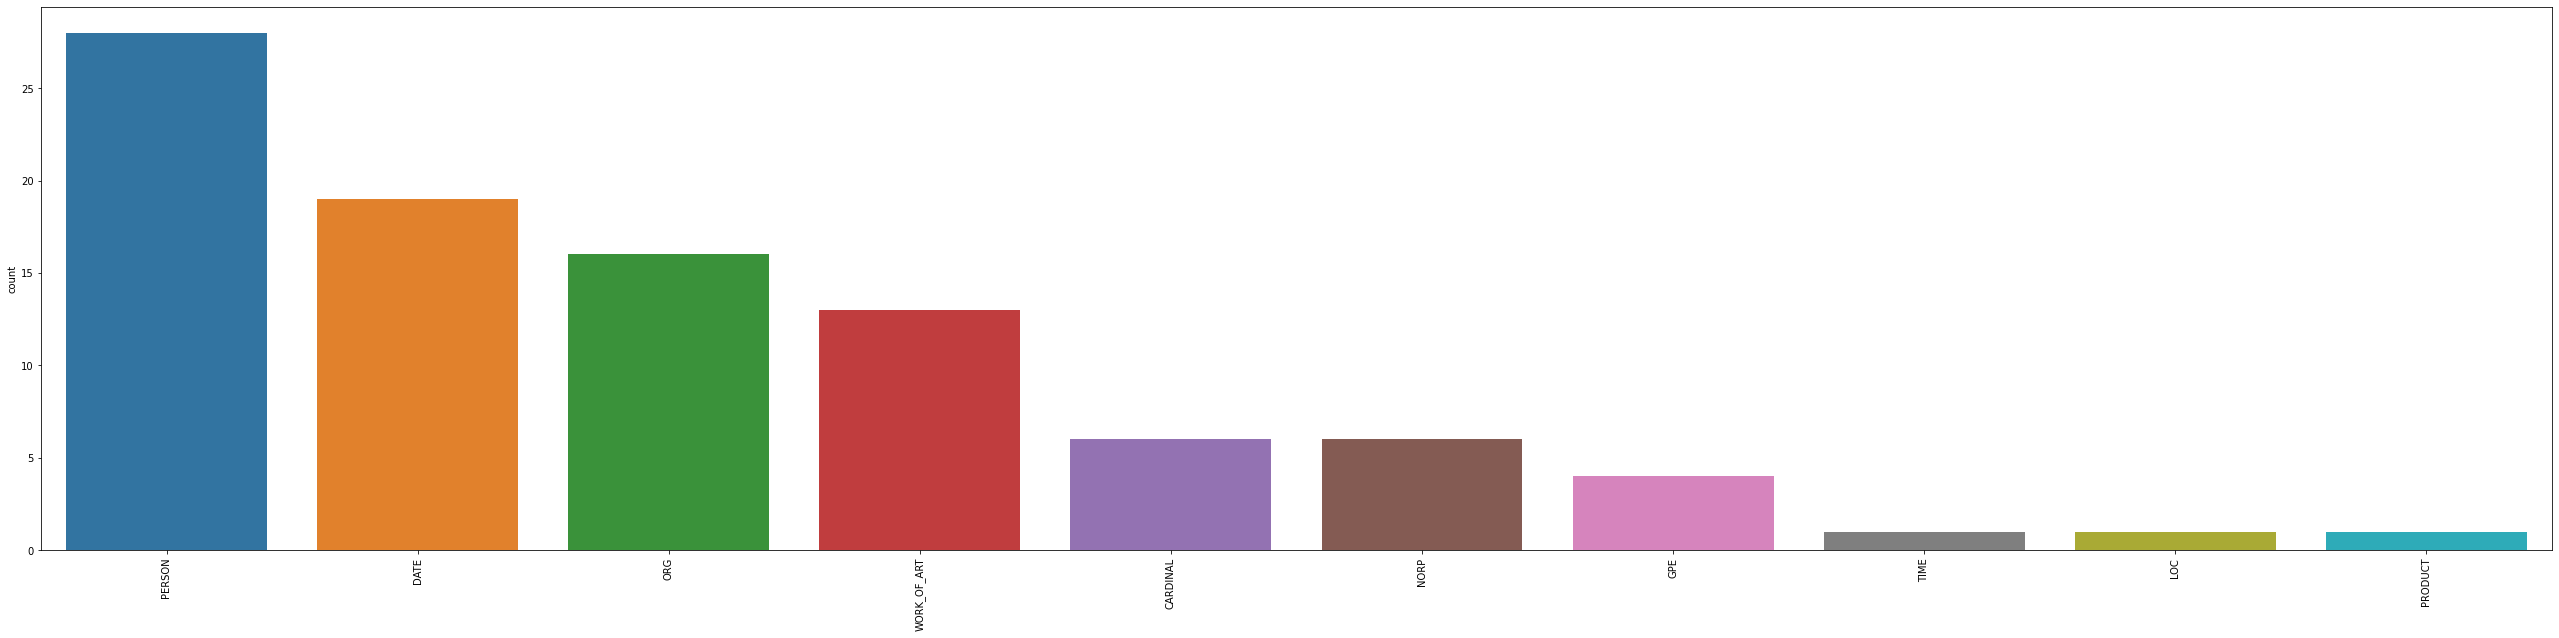

In [ ]:
plt.figure(figsize=(45,10))
sns.countplot(x=labels, order=pd.Series(labels).value_counts().index)
# sns.countplot(words_nostop, order=[counted[0] for counted in Counter(words_nostop).most_common()])
plt.xticks(rotation=90)
plt.show()

# NLP Part II

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Word embedding

#### Word2Vec
- Developed by [Mikolov et al., 2013](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- Represent the meaning of the words as a vector
    - Vector: numeric array
    - Output of a neural network model that predicts the next word
- Surprisingly, many different semantic informations can be represented from word vectors of ```Word2Vec```
- (More explanation in here: https://www.tensorflow.org/tutorials/representation/word2vec)

In [ ]:
# ! pip install gensim

You will also need to download a pretrained language model: https://github.com/eyaler/word2vec-slim/raw/master/GoogleNews-vectors-negative300-SLIM.bin.gz

In [ ]:
import gensim

Change the filepath in the next cell to correspond to the location of the pretrained model file you downloaded above.

In [ ]:
w2v_mod = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300-SLIM.bin.gz", binary=True)

## 1-1. Calculating similarity between words

- Q: What's similarity between *school* and *student*?

- the word vector for *school* looks like this:

In [ ]:
w2v_mod['school']

array([ 3.70471478e-02,  1.14410305e-02,  1.49575379e-02,  8.87546614e-02,
        3.96226160e-02, -2.67452672e-02,  6.33961856e-02, -1.90188568e-02,
       -1.89445645e-03, -3.68490331e-02,  1.01037674e-01,  1.85235739e-02,
        2.69433800e-02, -4.00188453e-02, -4.29905392e-02,  4.31886539e-02,
       -8.12263638e-02,  5.72051527e-03,  5.54716662e-02, -3.56603563e-02,
        8.32074955e-02,  6.93395808e-02,  4.72994987e-03,  6.97358102e-02,
        1.96874887e-03, -1.41848966e-01,  9.22464067e-04,  7.48867467e-02,
        4.85377051e-02, -1.02028241e-02,  4.14056368e-02, -4.33867648e-02,
        1.62452739e-02,  3.04598873e-03, -6.61697686e-02, -6.06226064e-02,
        9.27169248e-02, -2.04056483e-02,  1.88207440e-02,  5.07169515e-02,
        5.29952534e-03,  5.19056283e-02,  4.47735563e-02, -2.05047056e-02,
        1.39669729e-02,  5.86414747e-02,  6.97358102e-02, -1.12924464e-02,
       -4.49716710e-02,  9.31131542e-02, -4.75471430e-02, -4.95282710e-02,
       -1.44251098e-03, -

In [ ]:
len(w2v_mod['school'])

300

- and the word vector for *student* looks like this:

In [ ]:
w2v_mod['student']

array([ 0.01336551,  0.00730235,  0.08037006,  0.05629445,  0.06479172,
        0.01141821,  0.11400511, -0.01221483,  0.0559404 , -0.1359564 ,
        0.01849928, -0.04779717, -0.04337151, -0.05027555, -0.0073466 ,
        0.00477972, -0.02442967, -0.02389859, -0.00907261, -0.05098365,
        0.00783343,  0.06302146, -0.00064449, -0.03328099, -0.03540531,
       -0.17844278, -0.04956744, -0.002069  ,  0.06160524,  0.0366445 ,
        0.03416613, -0.03983098, -0.03080262,  0.01964995, -0.02372156,
       -0.00610742,  0.04071611,  0.0506296 , -0.03009452,  0.08072411,
       -0.08638897,  0.0426634 , -0.01672901,  0.03115668,  0.0619593 ,
       -0.02496075,  0.01451618, -0.03752963,  0.05771066,  0.0179682 ,
       -0.03947692, -0.05452418,  0.0054657 , -0.01964995,  0.0906376 ,
       -0.03452018, -0.04284043,  0.04036206,  0.07435116, -0.03629045,
        0.00610742, -0.03452018, -0.00111748, -0.00489036,  0.03363505,
       -0.0306256 ,  0.03080262, -0.02009252,  0.05735661,  0.03

In [ ]:
result = w2v_mod.similar_by_word("cat")
most_similar_key, similarity = result[-1]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")
# dog: 0.8798

chihuahua: 0.6710


- the similarity between two word vectors is:

In [ ]:
w2v_mod.similarity('school', 'computer')

0.17797627

### <font color='red'> Q1: Find a word that is more similar to school using this model </font>

In [ ]:
# insert your code here
w2v_mod.most_similar('school')

[('elementary', 0.7868632078170776),
 ('schools', 0.7411909103393555),
 ('shool', 0.6692329049110413),
 ('kindergarten', 0.6529810428619385),
 ('School', 0.6477997899055481),
 ('teacher', 0.63824063539505),
 ('students', 0.6301523447036743),
 ('classroom', 0.6281620860099792),
 ('Schools', 0.6172096133232117),
 ('teachers', 0.6158267259597778)]

"elementary" is a more similar word to school than student.

### <font color='red'> Q3 Try some other words. Any other interesting findings? </font>
- Give 2 more examples.
- How would you interprete the results?

In [ ]:
# put your code here
w2v_mod.similarity('big','small')

0.49586785

Even though big and small and kind of opposite in semantic, they are quite similar in syntax and have the same POS, that is why they are more similar than what we expected.

## 1-2. Analogy from word vectors

<img src="https://www.tensorflow.org/images/linear-relationships.png" width="800">

#### Can we approximate the relationship between words by doing - and + operations?

- $woman - man + king \approx ?$
- How this works?
    - $woman:man \approx x:king $
    - $\rightarrow woman - man \approx x - king $
    - $\rightarrow woman - man + king \approx x$
    - List top-10 words ($x$) that can solve the equation!

In [ ]:
w2v_mod.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189675331115723),
 ('princess', 0.5902431011199951),
 ('prince', 0.5377322435379028),
 ('kings', 0.5236844420433044),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454),
 ('throne', 0.5005807876586914),
 ('royal', 0.4938204884529114)]

- $Spain - Germany + Berlin \approx ?$
    - $\rightarrow Spain - Germany \approx x -  Berlin $

In [ ]:
w2v_mod.most_similar(positive=['Spain', 'Berlin'], negative=['Germany'])

[('Madrid', 0.7173480987548828),
 ('Barcelona', 0.5742595791816711),
 ('Malaga', 0.5547428727149963),
 ('Bilbao', 0.5404423475265503),
 ('Lisbon', 0.5366038680076599),
 ('Seville', 0.5312415361404419),
 ('Paris', 0.5251092314720154),
 ('Catalan', 0.5213972926139832),
 ('Rome', 0.5174577832221985),
 ('Bogota', 0.5146557688713074)]

In [ ]:
# put your code here
w2v_mod.most_similar(positive=['italy', 'barcelona'], negative=['spain'])

[('juventus', 0.6439997553825378),
 ('bayern', 0.6331779956817627),
 ('barca', 0.6162762641906738),
 ('italians', 0.6080244779586792),
 ('liverpool', 0.6065831184387207),
 ('ballack', 0.6042324304580688),
 ('capello', 0.5961124300956726),
 ('ronaldinho', 0.590697169303894),
 ('drogba', 0.5895470380783081),
 ('milan', 0.5877407789230347)]

In [ ]:
w2v_mod.most_similar(positive=['drink', 'food'], negative=['eat'])

[('drinks', 0.6746270656585693),
 ('beverage', 0.6164290904998779),
 ('beverages', 0.6013401746749878),
 ('drinking', 0.5713502168655396),
 ('beer', 0.5662599205970764),
 ('alcohol', 0.5321926474571228),
 ('Drinks', 0.5175540447235107),
 ('booze', 0.5061315894126892),
 ('Drink', 0.5040767788887024),
 ('liquor', 0.5028088092803955)]

# 2. Sentiment Analysis with NLTK

"The Natural Language Toolkit (NLTK) is a suite of libraries and programs for symbolic and statistical natural language processing for English written in the Python programming language."
for more information see: https://www.nltk.org/

We are going to use NLTK and Spacy to determine if text expresses positive sentiment, negative sentiment, or if it's neutral.

In [ ]:
# adapted from https://github.com/Jcharis/Natural-Language-Processing-Tutorials/blob/master/NLP%20with%20SpaCy-%20Adding%20Extensions%20Attributes%20in%20SpaCy(How%20to%20use%20sentiment%20analysis%20in%20SpaCy).ipynb

In [ ]:
#!pip install nltk
#!python -m nltk.downloader book

In [ ]:
import nltk

"VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media."

for more see: https://github.com/cjhutto/vaderSentiment

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

We are going to extend the spacy functionality with the SentimentIntensityAnalyzer function from NLTK.

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(docx):
    return sent_analyzer.polarity_scores(docx.text)

In [ ]:
import spacy

In [ ]:
# loading up the language model: English
nlp = spacy.load('en_core_web_sm')

In [ ]:
# from spacy.tokens import Doc
# Doc.set_extension("sentimenter",getter=sentiment_scores)

In [ ]:
nlp("This movie was very good")._.sentimenter

{'compound': 0.4927, 'neg': 0.0, 'neu': 0.556, 'pos': 0.444}

Let's apply this sentiment analysis to product reviews on Amazon

In [ ]:
r = pd.read_csv('https://raw.githubusercontent.com/umsi-data-science/data/main/small_reviews.csv')
#random sample of original dataset at https://www.kaggle.com/snap/amazon-fine-food-reviews

In [ ]:
r.head()

,Unnamed: 0,Score,Summary,Text
0,244509,4,Love Happy Tot,I just love the happy tot baby food line. It s...
1,87295,4,Feelin Hot Hot Hot,Curry has become one of my favorite foods over...
2,377094,5,Wow. Very Maple-y,"Just tried this for the first time, and I'm qu..."
3,44261,4,"Good dark, rich coffee for breakfast time",After trying lots of different blends in K-Cup...
4,398439,5,Fantastic coffee!,"Exceptional coffee all around - rich, full, wi..."


We'll use the apply function to transform text with spacy's nlp function.

In [ ]:
r['rating'] = r['Text'].apply(lambda x: nlp(x)._.sentimenter['compound'])

In [ ]:
r[['Score','rating','Text']].head(10)

,Score,rating,Text
0,4,0.9558,I just love the happy tot baby food line. It s...
1,4,0.9742,Curry has become one of my favorite foods over...
2,5,0.9383,"Just tried this for the first time, and I'm qu..."
3,4,0.8476,After trying lots of different blends in K-Cup...
4,5,0.5983,"Exceptional coffee all around - rich, full, wi..."
5,5,0.9652,These are a delicious vegan alternative to reg...
6,1,-0.6048,I have never cared for sweetened cereal as I w...
7,3,0.8029,I've been looking for dried organic mango that...
8,3,-0.1971,"This meal-in-a-box was alright, but not amazin..."
9,4,0.2732,This product works well with most kinds of mea...


In [ ]:
r.iloc[6].Text

"I have never cared for sweetened cereal as I was not raised on it. When I found Purely O's a few years ago I was happy to have found a cereal that did not contain sugar or corn products which I need to avoid because of a corn allergy.  I had intended to buy another box today. I took the time to read the label to make sure that nothing had changed. I could not believe that the ingredient list now lists CORN!  I am so angry!  Purely O's were my go-to breakfast when I needed a something quick or was in the mood for cereal.  There is nothing that this  company makes that I can now eat.  When will these people learn humans aren't pigs! Everything in a supermarket should not contain corn!  If I had wanted corny oat cereal I would have bought Cheerios."

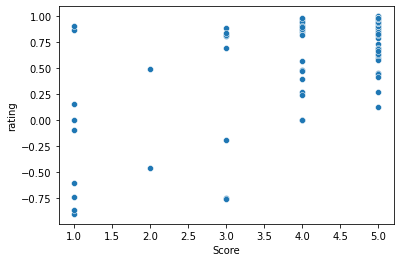

In [ ]:
sns.scatterplot(x='Score',y='rating',data=r)

In [ ]:
r[(r['Score'] == 1) & (r['rating'] >= 0.75)]

,Unnamed: 0,Score,Summary,Text,rating
18,90807,1,Moist and Juicy... NOT...,I like a variety of jerky but this Peppered st...,0.8631
66,479534,1,"Very Disappointed, Not Durable at All",I bought this toy because it touted being the ...,0.9020


In [ ]:
r.iloc[18].Text

"I like a variety of jerky but this Peppered style from Oh Boy! all I can say is Oh NO!!!!!! Thin sliced is OK but not when it is as dry as cardboard. I did not like this product at all. I don't usually do reviews but I felt I had to give my opinion on this one. I will NOT be buying this one again... Sorry Oh Boy! Oberto..."

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
model0 = smf.ols("rating ~ Score ", data=r)
model0.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     73.92
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           1.32e-13
Time:                        21:30:22   Log-Likelihood:                -38.820
No. Observations:                 100   AIC:                             81.64
Df Residuals:                      98   BIC:                             86.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3960      0.128     -3.094      0.003      -0.650      -0.142
Score          0.2508      0.029      8.598      0.000       0.193       0.309
==============================================================================
Omnibus:                       11.481   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.888
Skew:                          -0.548   Prob(JB):                     0.000355
Kurtosis:                       4.617   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""